# Step 5.2 — Evaluate FinBERT Sentiment vs. Stock Price Movements

This notebook evaluates whether **FinBERT** sentiment predictions on financial news  
correlate with actual stock-price movements for **AAPL** and **MSFT**.

**Pipeline:**
1. Load all raw news → run FinBERT inference via `SentimentAnalyzer`.
2. Assign articles to trading days, aggregate daily FinBERT sentiment.
3. Merge with price data (daily returns, direction).
4. Correlation analysis (Pearson, Spearman, direction accuracy).
5. Lag analysis — does today's sentiment predict *tomorrow's* return?
6. Quintile analysis — are returns higher when sentiment is most positive?
7. Decide whether fine-tuning is warranted.

In [1]:
import sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats

# Ensure project root is on sys.path
PROJECT_ROOT = Path.cwd().resolve().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.models.sentiment_analyzer import SentimentAnalyzer
from src.data.data_loader import (
    load_all_news, load_all_prices,
    add_session_column, assign_trading_day,
    add_price_features,
)

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams.update({"figure.dpi": 120, "axes.titlesize": 13, "axes.labelsize": 11})
print(f"Project root: {PROJECT_ROOT}")

c:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: C:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis


## 1 — Load news & run FinBERT inference

In [2]:
# Load raw news and price data
news = load_all_news()
prices = load_all_prices()
prices = add_price_features(prices)

print(f"News articles: {len(news)}")
print(f"Price rows:    {len(prices)}")
print(f"Tickers:       {news['ticker'].unique().tolist()}")
news.head(2)

News articles: 100
Price rows:    140
Tickers:       ['MSFT', 'AAPL']


,title,summary,source,url,published_at,authors,overall_sentiment_score,overall_sentiment_label,ticker_sentiment_score,ticker_sentiment_label,ticker,date
0,JFrog (FROG) Q4 2025 Earnings Call Transcript,"JFrog reported a strong Q4 and full-year 2025,...",The Globe and Mail,https://www.theglobeandmail.com/investing/mark...,2026-02-12 22:27:44,Motley Fool,0.310229,Somewhat-Bullish,0.090416,Neutral,MSFT,2026-02-12
1,Apple has worst day since April as company fac...,Apple experienced its worst stock market day s...,CNBC,https://www.cnbc.com/2026/02/12/apple-stock-wo...,2026-02-12 21:56:42,Jennifer Elias,-0.601882,Bearish,-0.606083,Bearish,AAPL,2026-02-12


In [3]:
# Instantiate FinBERT
analyzer = SentimentAnalyzer()  # ProsusAI/finbert on best available device

[SentimentAnalyzer] Loading 'ProsusAI/finbert' on cpu ...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 920.32it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[SentimentAnalyzer] Ready — 109,484,547 parameters, labels: ['positive', 'negative', 'neutral']


In [4]:
# Run inference on title + summary columns
news_with_preds = analyzer.predict_dataframe(
    news,
    text_columns=["title", "summary"],
    batch_size=16,
)
news_with_preds[["title", "finbert_title_label", "finbert_title_score",
                 "finbert_summary_label", "finbert_summary_score"]].head()

[SentimentAnalyzer] Predicting on 'title' (100 texts, batch_size=16) ...
  Processed 100/100 texts
[SentimentAnalyzer] Predicting on 'summary' (100 texts, batch_size=16) ...
  Processed 100/100 texts


,title,finbert_title_label,finbert_title_score,finbert_summary_label,finbert_summary_score
0,JFrog (FROG) Q4 2025 Earnings Call Transcript,neutral,0.0133,positive,0.9394
1,Apple has worst day since April as company fac...,negative,-0.9440,negative,-0.9646
2,Expedia (NASDAQ:EXPE) Beats Expectations in St...,positive,0.9119,negative,-0.9566
3,LiveOne Inc (LVO) Q3 2026 Earnings Call Highli...,positive,0.9343,positive,0.9169
4,JFrog (NASDAQ:FROG) Reports Bullish Q4 CY2025 ...,negative,-0.9575,negative,-0.8890


## 2 — Assign trading days & aggregate daily sentiment

In [5]:
# Classify sessions and assign to trading days
news_with_preds = add_session_column(news_with_preds)
trading_dates = prices["date"].drop_duplicates()
news_with_preds = assign_trading_day(news_with_preds, trading_dates)

# Aggregate FinBERT sentiment per trading day per ticker
fb_daily = analyzer.aggregate_daily_sentiment(
    news_with_preds,
    score_column="finbert_summary_score",
)

print(f"Daily sentiment rows: {len(fb_daily)}")
fb_daily.head()

[INFO] Dropped 21 articles outside trading-date range.
Daily sentiment rows: 5


,trading_day,ticker,fb_article_count,fb_avg_sentiment,fb_min_sentiment,fb_max_sentiment,fb_sentiment_std,fb_pct_positive,fb_pct_negative
0,2026-02-10,AAPL,17.0,0.472147,-0.9665,0.9405,0.634426,0.764706,0.117647
1,2026-02-11,AAPL,10.0,0.212900,-0.9634,0.9373,0.832978,0.600000,0.300000
2,2026-02-11,MSFT,5.0,0.524000,-0.9601,0.9396,0.831754,0.800000,0.200000
3,2026-02-12,AAPL,14.0,0.528214,-0.9659,0.9426,0.685805,0.785714,0.142857
4,2026-02-12,MSFT,33.0,0.316552,-0.9640,0.9401,0.817643,0.696970,0.272727


## 3 — Merge with price data

In [6]:
# Merge FinBERT daily sentiment with price returns
merged = pd.merge(
    prices,
    fb_daily,
    left_on=["date", "ticker"],
    right_on=["trading_day", "ticker"],
    how="left",
).drop(columns=["trading_day"], errors="ignore")

merged["fb_article_count"] = merged["fb_article_count"].fillna(0).astype(int)

# Keep only days with at least 1 article for correlation analysis
has_news = merged[merged["fb_article_count"] > 0].copy()

print(f"Total rows:          {len(merged)}")
print(f"Rows with FinBERT:   {len(has_news)}")
has_news[["date", "ticker", "Close", "daily_return", "return_direction",
          "fb_article_count", "fb_avg_sentiment"]].head(10)

Total rows:          140
Rows with FinBERT:   5


,date,ticker,Close,daily_return,return_direction,fb_article_count,fb_avg_sentiment
67,2026-02-10,AAPL,273.679993,-0.342292,0,17,0.472147
68,2026-02-11,AAPL,275.500000,0.665013,1,10,0.212900
69,2026-02-12,AAPL,261.730011,-4.998181,0,14,0.528214
138,2026-02-11,MSFT,404.369995,-2.153554,0,5,0.524000
139,2026-02-12,MSFT,401.839996,-0.625664,0,33,0.316552


## 4 — Correlation analysis (same-day)

In [7]:
# Use the built-in evaluate method
eval_results = analyzer.evaluate_price_correlation(
    has_news,
    sentiment_col="fb_avg_sentiment",
    return_col="daily_return",
    direction_col="return_direction",
)

# Print overall metrics
print("=" * 55)
print("  OVERALL CORRELATION")
print("=" * 55)
for k, v in eval_results["overall"].items():
    print(f"  {k:>22s} : {v}")

print("\n  PER-TICKER")
for ticker, metrics in eval_results.get("per_ticker", {}).items():
    print(f"\n  --- {ticker} ---")
    for k, v in metrics.items():
        print(f"    {k:>22s} : {v}")

  OVERALL CORRELATION
                       n : 5
               pearson_r : -0.7485
               pearson_p : 0.1455
              spearman_r : -0.9
              spearman_p : 0.0374
      direction_accuracy : 0.2

  PER-TICKER


C:\Users\yagoc\AppData\Local\Temp\ipykernel_24060\2658970660.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


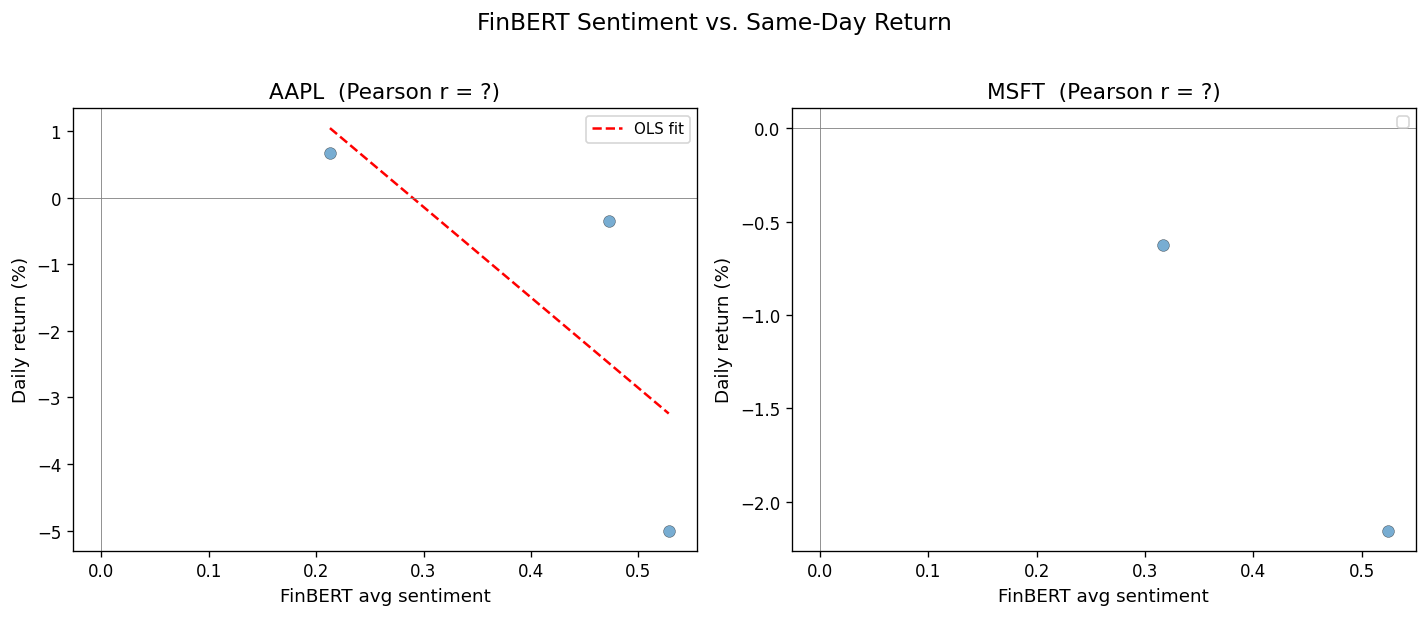

In [8]:
# Scatter plot: FinBERT sentiment vs daily return (per ticker)
tickers = has_news["ticker"].unique()
fig, axes = plt.subplots(1, len(tickers), figsize=(6 * len(tickers), 5), squeeze=False)

for i, ticker in enumerate(sorted(tickers)):
    ax = axes[0, i]
    sub = has_news[has_news["ticker"] == ticker]
    ax.scatter(sub["fb_avg_sentiment"], sub["daily_return"],
               alpha=0.6, edgecolors="k", linewidths=0.3, s=50)

    # Trend line
    if len(sub) > 2:
        z = np.polyfit(sub["fb_avg_sentiment"], sub["daily_return"], 1)
        xs = np.linspace(sub["fb_avg_sentiment"].min(), sub["fb_avg_sentiment"].max(), 50)
        ax.plot(xs, np.polyval(z, xs), "r--", lw=1.5, label="OLS fit")

    r = eval_results["per_ticker"].get(ticker, {}).get("pearson_r", "?")
    ax.set_title(f"{ticker}  (Pearson r = {r})")
    ax.set_xlabel("FinBERT avg sentiment")
    ax.set_ylabel("Daily return (%)")
    ax.axhline(0, color="grey", lw=0.5)
    ax.axvline(0, color="grey", lw=0.5)
    ax.legend(fontsize=9)

fig.suptitle("FinBERT Sentiment vs. Same-Day Return", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()

## 5 — Lag analysis: t+0, t+1, t+2

Lag Analysis:
     pearson_r  pearson_p    n
t+0    -0.7485     0.1455  5.0


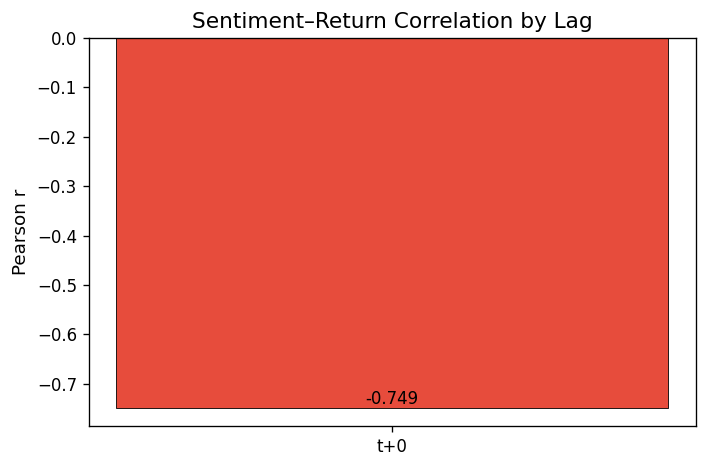

In [9]:
# Lag analysis results from evaluate_price_correlation
lag_data = eval_results.get("lag_analysis", {})

if lag_data:
    lag_df = pd.DataFrame(lag_data).T
    print("Lag Analysis:")
    print(lag_df.to_string())

    # Bar chart
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ["#2ecc71" if r > 0 else "#e74c3c" for r in lag_df["pearson_r"]]
    bars = ax.bar(lag_df.index, lag_df["pearson_r"], color=colors, edgecolor="k", lw=0.5)
    for bar, p in zip(bars, lag_df["pearson_p"]):
        sig = "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.1 else ""
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{bar.get_height():.3f}{sig}", ha="center", va="bottom", fontsize=10)
    ax.set_ylabel("Pearson r")
    ax.set_title("Sentiment–Return Correlation by Lag")
    ax.axhline(0, color="grey", lw=0.5)
    fig.tight_layout()
    plt.show()
else:
    print("Not enough data for lag analysis.")

## 6 — Quintile analysis: average return by sentiment bucket

                    avg_return  med_return    n
Sentiment quintile                             
Q1                    0.665013    0.665013  1.0
Q2                   -0.625664   -0.625664  1.0
Q3                   -0.342292   -0.342292  1.0
Q4                   -2.153554   -2.153554  1.0
Q5                   -4.998181   -4.998181  1.0


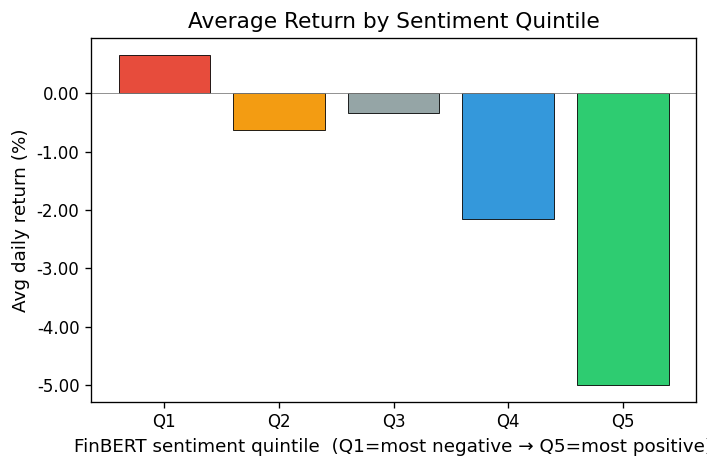

In [10]:
quintile_data = eval_results.get("quintile_returns", {})

if quintile_data:
    q_df = pd.DataFrame(quintile_data).T
    q_df.index = [f"Q{int(i)+1}" for i in q_df.index]
    q_df.index.name = "Sentiment quintile"
    print(q_df.to_string())

    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ["#e74c3c", "#f39c12", "#95a5a6", "#3498db", "#2ecc71"]
    ax.bar(q_df.index, q_df["avg_return"], color=colors[:len(q_df)], edgecolor="k", lw=0.5)
    ax.set_ylabel("Avg daily return (%)")
    ax.set_xlabel("FinBERT sentiment quintile  (Q1=most negative → Q5=most positive)")
    ax.set_title("Average Return by Sentiment Quintile")
    ax.axhline(0, color="grey", lw=0.5)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
    fig.tight_layout()
    plt.show()
else:
    print("Not enough data for quintile analysis.")

## 7 — Direction accuracy : positive sentiment → positive return?

In [11]:
# Direction accuracy breakdown
has_news["pred_direction"] = (has_news["fb_avg_sentiment"] > 0).astype(int)

for ticker in sorted(tickers):
    sub = has_news[has_news["ticker"] == ticker]
    acc = (sub["pred_direction"] == sub["return_direction"]).mean()
    n = len(sub)
    print(f"{ticker}:  direction accuracy = {acc:.2%}  (n={n})")

    # Confusion-style breakdown
    ct = pd.crosstab(
        sub["pred_direction"].map({0: "Neg sentiment", 1: "Pos sentiment"}),
        sub["return_direction"].map({0: "Down", 1: "Up"}),
    )
    print(ct)
    print()

AAPL:  direction accuracy = 33.33%  (n=3)
return_direction  Down  Up
pred_direction            
Pos sentiment        2   1

MSFT:  direction accuracy = 0.00%  (n=2)
return_direction  Down
pred_direction        
Pos sentiment        2



## 8 — Comparison: FinBERT vs Alpha Vantage baseline

In [12]:
# Also compute Alpha Vantage correlation for comparison
# (AV scores come from the original merged dataset's avg_overall_sentiment)
from src.data.data_loader import load_merged_dataset

av_merged = load_merged_dataset()
av_has_news = av_merged[av_merged["article_count"] > 0].copy()

# AV same-day correlation
av_valid = av_has_news.dropna(subset=["avg_overall_sentiment", "daily_return"])
if len(av_valid) > 5:
    av_r, av_p = stats.pearsonr(av_valid["avg_overall_sentiment"], av_valid["daily_return"])
else:
    av_r, av_p = float("nan"), float("nan")

fb_r = eval_results["overall"]["pearson_r"]
fb_p = eval_results["overall"]["pearson_p"]

print("Sentiment Source          | Pearson r | p-value  | Dir. Accuracy")
print("-" * 68)
print(f"Alpha Vantage (baseline)  | {av_r:+.4f}   | {av_p:.4f}  | —")
print(f"FinBERT (ProsusAI)        | {fb_r:+.4f}   | {fb_p:.4f}  | "
      f"{eval_results['overall']['direction_accuracy']:.2%}")

[1/7] Loading news CSVs ...
       → 100 articles loaded.
[2/7] Loading price CSVs ...
       → 140 price rows loaded.
[3/7] Classifying market sessions ...
       → Sessions: {'market_hours': 36, 'after_hours': 26, 'overnight': 23, 'pre_market': 15}
[4/7] Assigning articles to trading days ...
[INFO] Dropped 21 articles outside trading-date range.
       → 79 articles matched to trading days.
[5/7] Aggregating daily sentiment ...
       → 5 daily-sentiment rows.
[6/7] Computing price features ...
[7/7] Merging & adding rolling sentiment ...

  Final dataset: 140 rows × 28 columns
  Tickers: ['AAPL', 'MSFT']
  Date range: 2025-11-03 → 2026-02-12
  Trading days with news: 5 / 140
Sentiment Source          | Pearson r | p-value  | Dir. Accuracy
--------------------------------------------------------------------
Alpha Vantage (baseline)  | +nan   | nan  | —
FinBERT (ProsusAI)        | -0.7485   | 0.1455  | 20.00%


## 9 — Conclusion & fine-tuning decision

**Interpretation guide:**

| Metric | Good sign | Bad sign |
|--------|-----------|----------|
| Pearson r | ≥ 0.15 (statistically significant) | < 0.05 or negative |
| Direction accuracy | > 55% | ≤ 50% (coin-flip) |
| Quintile spread | Q5 return >> Q1 return | Flat across quintiles |
| Lag analysis | t+1 stronger than t+0 | No signal at any lag |

**If accuracy is insufficient,** use the fine-tuning API:

```python
from src.models.sentiment_analyzer import SentimentAnalyzer

analyzer = SentimentAnalyzer()

# Prepare labelled data (e.g. from Alpha Vantage categories or manual labels)
train_df = ...  # must have 'summary' and 'label' columns
val_df   = ...  # optional validation set

history = analyzer.fine_tune(
    train_df,
    text_col="summary",
    label_col="label",
    val_df=val_df,
    epochs=3,
    lr=2e-5,
    save_path="models/saved_models/finbert_finetuned"
)

# Reload later
analyzer = SentimentAnalyzer.load("models/saved_models/finbert_finetuned")
```

In [13]:
# Summary verdict
dir_acc = eval_results["overall"]["direction_accuracy"]
r_val = eval_results["overall"]["pearson_r"]

print("\n" + "=" * 60)
print("  EVALUATION SUMMARY")
print("=" * 60)
print(f"  Pearson r (sentiment vs return) : {r_val:+.4f}")
print(f"  Direction accuracy              : {dir_acc:.2%}")

if dir_acc > 0.55 and abs(r_val) > 0.10:
    verdict = "ADEQUATE — FinBERT provides a useful signal."
elif dir_acc > 0.50:
    verdict = ("MARGINAL — slight edge over random. "
               "Consider fine-tuning on domain data.")
else:
    verdict = ("INSUFFICIENT — no better than coin-flip. "
               "Fine-tuning is recommended.")

print(f"  Verdict: {verdict}")
print("=" * 60)


  EVALUATION SUMMARY
  Pearson r (sentiment vs return) : -0.7485
  Direction accuracy              : 20.00%
  Verdict: INSUFFICIENT — no better than coin-flip. Fine-tuning is recommended.


## 10 — Low accuracy Fix: More data + Fine-tune FinBERT

We downloaded **3x more news** (100 → 300 articles, covering Nov 2025 – Feb 2026).
Now we:
1. Reload the expanded dataset
2. Convert Alpha Vantage labels to FinBERT format (positive / negative / neutral)
3. Fine-tune FinBERT for 3 epochs on 80% of the data
4. Re-evaluate on the held-out 20% and on price correlation